In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline

In [2]:
Data = pd.read_excel('Data compilation.xlsx',sheetname='DataCompiled',skiprows=[0,1,2])

In [3]:
TreatmentList = Data.TrtNum.drop_duplicates().values
print('TreatmentList')
print(TreatmentList)
YearList = Data.YearSown.drop_duplicates().values
print('YearList')
print(YearList)
Factors = ['Cultivar','SowingDate','PlantPopn','PGRCanopyMgmtTrt']

MetaIndex = pd.MultiIndex.from_product([YearList, TreatmentList])
GrandIndex = pd.DataFrame(index = MetaIndex, columns = Factors)
GrandIndex.sort_index(inplace=True)

print('Null Combos')
for Year in YearList:
    for Treat in TreatmentList:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
        Indicies = Data.ix[Filter,Data.columns.isin(Factors)].drop_duplicates().values
        try:
            GrandIndex.ix[(Year,Treat)] = Indicies
        except:
            print(str(Year)+' '+str(Treat))

GrandIndex.dropna(how='all',inplace=True)

for Treat in GrandIndex.index:
    GrandIndex.ix[Treat,'SowingDate'] = GrandIndex.ix[Treat,'SowingDate'].to_datetime()

TreatmentList
[u'2a' u'2e' u'1a' u'1e' u'3a' u'3e' u'2c' u'1c' u'3c' u'1d' u'1b' u'2f'
 u'2d' u'2b' u'3b' u'3d' u'4a' u'4d' u'4b' u'4c']
YearList
[2013 2014 2015]
Null Combos
2013 4a
2013 4d
2013 4b
2013 4c
2014 2e
2014 1e
2014 3e
2014 2f
2015 2e
2015 1e
2015 3e
2015 2f


In [4]:
ValuesToZero = ['LeafNum',
'NumLeafTips',
'NumLigules',
'PercentSenescence',
'NumGreenLeaves',
'NumSenescingLeaves',
'NumDeadLeaves',
'TotalBiomass',
'TotalLeafBiomass',
'GreenLeafBiomass',
'DeadLeafBiomass',
'LAI',
'CorrLightInterception',
'CorrLAI',
'NDVI',
'NDVIHC',
'WDVI',
'NDVISC']

ZeroData = pd.DataFrame(index = GrandIndex.index, columns = Data.columns)
for treat in ZeroData.index:
    ZeroData.ix[treat,'SampleDate'] = GrandIndex.ix[treat,'SowingDate']
    ZeroData.ix[treat,'Cultivar'] = GrandIndex.ix[treat,'Cultivar']
    ZeroData.ix[treat,'SowingDate'] = GrandIndex.ix[treat,'SowingDate']
    ZeroData.ix[treat,'PlantPopn'] = GrandIndex.ix[treat,'PlantPopn']
    ZeroData.ix[treat,'PGRCanopyMgmtTrt'] = GrandIndex.ix[treat,'PGRCanopyMgmtTrt']
    ZeroData.ix[treat,'YearSown'] = treat[0]
    ZeroData.ix[treat,'TrtNum'] = treat[1]
    for val in ValuesToZero:
        ZeroData.ix[treat,val] = 0.0
for val in ValuesToZero:
    ZeroData.ix[:,val] = ZeroData.ix[:,val].convert_objects(convert_numeric=True)
ZeroData.reset_index(level=[0,1],inplace=True,drop=True)

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:32: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [5]:
Data = Data.append(ZeroData)
Data.set_index('SampleDate',inplace=True)
filter = Data.YearSown == 2013
Data.ix[filter,'I/Io'] = Data.ix[filter,'CorrLightInterception']
filter = Data.YearSown != 2013
Data.ix[filter,'I/Io'] = Data.ix[filter,'NDVISC']

In [6]:
for Treat in GrandIndex.index:
    GrandIndex.ix[Treat,'SowingDate'] = GrandIndex.ix[Treat,'SowingDate'].strftime('%d-%b')

TreatmentOrder = ['SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt']
GrandIndex = GrandIndex[TreatmentOrder]

In [7]:
def MakeLabel(Treat):
    label = ''
    for level in Treat.index:
        label += str(Treat.ix[level]) + ' '
    return label

In [8]:
def SetDemarkers(Index):
    Colors = ['red','orange','blue','green']
    Markers = ['o','s','^','*']
    Sizes = [12,10,8,6,4,2]
    Demarkers = [Colors, Markers, Sizes]
    DemarkerIndex = []
    FactorNumber = 0
    for Fact in Index.columns:
        LevelList = GraphTreats.ix[:,Fact].drop_duplicates().values
        FactorLevels = LevelList.size
        LevelDemarkers = Demarkers[FactorNumber][0:FactorLevels]
        LevelPairs = pd.Series(data=LevelDemarkers, index=LevelList)
        DemarkerIndex.append(LevelPairs)
        FactorNumber +=1
    return DemarkerIndex

In [9]:
Data.columns

Index([              u'TrialCode',                u'YearSown',
                        u'Farmer',                u'Location',
                          u'Plot',           u'TrialCodePlot',
                        u'TrtNum',                   u'Block',
                      u'Cultivar',              u'SowingDate',
                     u'PlantPopn',                  u'PGRTrt',
                     u'PGRTiming',        u'PGRCanopyMgmtTrt',
                          u'NTrt',                u'ApproxGS',
                u'ReassessmentGS',                u'PlantNum',
                       u'LeafNum',             u'NumLeafTips',
                    u'NumLigules',                   u'ttFeb',
                         u'ttMar',                   u'ttApr',
               u'LeafPositionNum',            u'LeafPosition',
                    u'AvLeafSize',            u'AvLeafWeight',
                         u'AvSLA',       u'PercentSenescence',
                u'NumGreenLeaves',      u'NumSenescingL

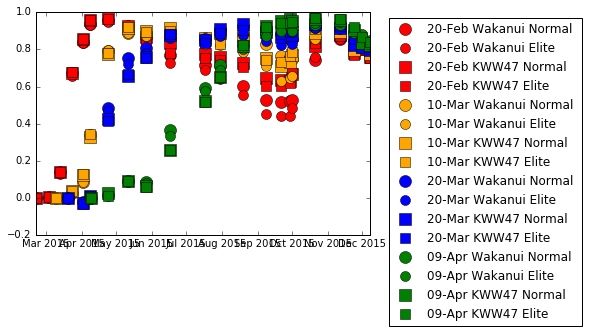

In [10]:
Year = 2015
GraphData = Data.ix[Data.YearSown==Year]
GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
Demarkers = SetDemarkers(GraphTreats)

for Treat in GraphTreats.index:
    Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
    GraphData = Data.ix[Filter,'I/Io'].dropna().groupby(level='SampleDate').mean()
    col = Demarkers[0][GraphTreats.ix[Treat][0]]
    mark = Demarkers[1][GraphTreats.ix[Treat][1]]
    try:
        size = Demarkers[2][GraphTreats.ix[Treat][2]]
    except:
        size = 8
    plt.plot(GraphData,mark,color = col, markersize = size,label = MakeLabel(GraphTreats.ix[Treat,:]))
plt.legend(bbox_to_anchor=(1.65, 1),numpoints=1)

In [11]:
MetData = pd.read_csv('LincolnClean.met',sep='\t')
MetData.set_index('Date', inplace=True)
MetData.index = MetData.index.to_datetime()
MetData.ix[:,'MeanT'] = np.divide(np.add(MetData.ix[:,'MinT'],MetData.ix[:,'MaxT']),2)
MetData.ix[:,'Tt'] = MetData.ix[:,'MeanT'].cumsum()

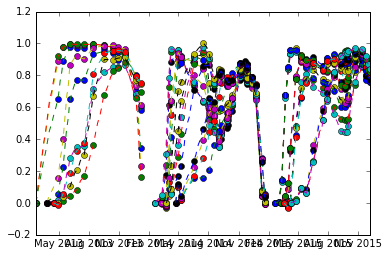

In [63]:
VarToInt = 'I/Io'
InterpolationIndex = pd.MultiIndex.from_product([YearList,TreatmentList,MetData.ix['2013-02-01':].index], names=['year', 'TrtNum', 'Date'])
BiomassAnalysis = pd.DataFrame(index = InterpolationIndex, columns=[VarToInt])
for Year in [2013,2014,2015]:
    YearData = Data.ix[Data.YearSown==Year,:]
    YearIndex = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Filter = YearData.TrtNum == Treat
        TreatCover = YearData.ix[Filter,VarToInt].dropna().groupby(level='SampleDate').mean()
        plt.plot(TreatCover,'o')
        Dates = TreatCover.index
        ArrayTt = MetData.ix[Dates,'Tt']
        InterpDates = MetData.ix[Dates.min():Dates.max()].index
        dailyTt = MetData.ix[InterpDates,'Tt']
        InterpCover = np.interp(dailyTt,ArrayTt,TreatCover)
        TreatIndex = pd.MultiIndex.from_product([Year,Treat,InterpDates],names=['Year', 'TrtNum', 'Date'])
        InterpDF = pd.DataFrame(index = TreatIndex, data=InterpCover,columns=[VarToInt])
        plt.plot(InterpDates, InterpDF.ix[:,VarToInt],'--')
        BiomassAnalysis.update(InterpDF)

In [64]:
BiomassAnalysis.dropna(inplace=True)

In [66]:
for Year in [2013,2014,2015]:
    YearData = Data.ix[Data.YearSown==Year,:]
    YearIndex = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Rad = MetData.ix[BiomassAnalysis.ix[(Year,Treat),:].index,'Radn']
        Temp = MetData.ix[BiomassAnalysis.ix[(Year,Treat),:].index,'MeanT']
        BiomassAnalysis.ix[(Year,Treat),'Radn'] = Rad.values
        BiomassAnalysis.ix[(Year,Treat),'Temp'] = Temp.values

In [67]:
BiomassAnalysis.ix[:,'IntRadn'] = BiomassAnalysis.ix[:,VarToInt] * BiomassAnalysis.ix[:,'Radn']
XTemp = [-10,0,15,25,35]
YRUE = [0,0,14,14,0]
BiomassAnalysis.ix[:,'RUE'] = [np.interp(BiomassAnalysis.ix[x,'Temp'],XTemp,YRUE) for x in BiomassAnalysis.index]
BiomassAnalysis.ix[:,'PotDM'] = BiomassAnalysis.ix[:,'RUE'] * BiomassAnalysis.ix[:,'IntRadn']

(array([ 735658.,  735689.,  735719.,  735750.,  735780.,  735811.,
         735842.,  735872.,  735903.,  735933.,  735964.,  735995.]),
 <a list of 12 Text xticklabel objects>)

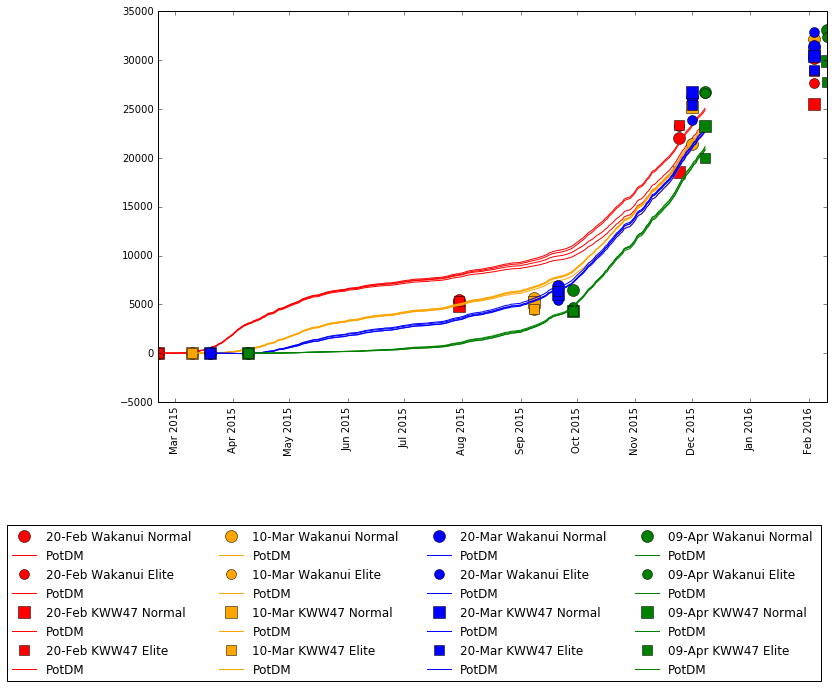

In [71]:
Year = 2015
GraphData = Data.ix[Data.YearSown==Year]
GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
Demarkers = SetDemarkers(GraphTreats)
Graph = plt.figure(figsize=(12,7))

for Treat in GraphTreats.index:
    Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
    GraphData = Data.ix[Filter,'TotalBiomass'].dropna().groupby(level='SampleDate').mean()
    col = Demarkers[0][GraphTreats.ix[Treat][0]]
    mark = Demarkers[1][GraphTreats.ix[Treat][1]]
    try:
        size = Demarkers[2][GraphTreats.ix[Treat][2]]
    except:
        size = 8
    plt.plot(GraphData,mark,color = col, markersize = size,label = MakeLabel(GraphTreats.ix[Treat,:]))
    Potbiomass = BiomassAnalysis.ix[(Year,Treat),'PotDM'].cumsum()
    plt.plot(Potbiomass,'-', color=col)
plt.legend(bbox_to_anchor=(1, -0.3),numpoints=1,ncol=4)
plt.xticks(rotation=90)

(array([ 735293.,  735354.,  735415.,  735477.,  735538.,  735599.,
         735658.,  735719.,  735780.,  735842.,  735903.]),
 <a list of 11 Text xticklabel objects>)

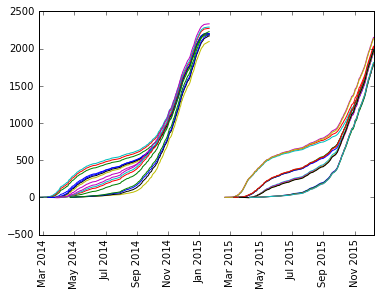

In [53]:
for Year in [2014,2015]:
    GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in GraphTreats.index:
        PotDM = BiomassAnalysis.ix[(Year,Treat),'PotDM'].cumsum()
        plt.plot(PotDM)
plt.xticks(rotation=90)

In [46]:
BiomassAnalysis

NDVISC   Radn    IntRadn   Temp    RUE      PotDM
year TrtNum Date                                                             
2014 2a     2014-03-10           0  10.75          0  13.50  1.080          0
            2014-03-11 -0.00239855  10.00 -0.0239855  14.90  1.192 -0.0285907
            2014-03-12  -0.0047327  14.34 -0.0678669  14.50  1.160 -0.0787256
            2014-03-13 -0.00713929  18.84  -0.134504  14.95  1.196  -0.160867
            2014-03-14 -0.00961833  17.06  -0.164089  15.40  1.200  -0.196906
            2014-03-15  -0.0120732  12.96  -0.156469  15.25  1.200  -0.187763
            2014-03-16  -0.0147937   7.07  -0.104592  16.90  1.200   -0.12551
            2014-03-17  -0.0182306  18.88  -0.344193  21.35  1.200  -0.413031
            2014-03-18  -0.0209591   9.76  -0.204561  16.95  1.200  -0.245473
            2014-03-19  -0.0237762  16.39  -0.389692  17.50  1.200   -0.46763
            2014-03-20  -0.0261989  12.34  -0.323294  15.05  1.200  -0.387953
            2014-03-21  -0.0279938  18.96  -0.530762  11.15  0.892  -0.473439
            2014-03-22  -0.0299416  19.73  -0.590747  12.10  0.968  -0.571843
            2014-03-23  -0.0320423  18.57  -0.595026  13.05  1.044  -0.621207
            2014-03-24  -0.0346018  18.81  -0.650861  15.90  1.200  -0.781033
            2014-03-25  -0.0268498   5.47  -0.146868  12.80  1.024  -0.150393
            2014-03-26  -0.0204906  18.19  -0.372724  10.50  0.840  -0.313088
            2014-03-27  -0.0117695  17.68  -0.208085  14.40  1.152  -0.239714
            2014-03-28 -0.00471392  16.85 -0.0794296  11.65  0.932 -0.0740284
            2014-03-29  0.00518815   9.59  0.0497544  16.35  1.200  0.0597053
            2014-03-30   0.0146966   9.23   0.135649  15.70  1.200   0.162779
            2014-03-31   0.0233874  10.72   0.250713  14.35  1.148   0.287818
            2014-04-01   0.0322902   5.83   0.188252  14.70  1.176   0.221384
            2014-04-02   0.0414049  12.73   0.527085  15.05  1.200   0.632501
            2014-04-03   0.0723861  12.27   0.888177  16.15  1.200    1.06581
            2014-04-04    0.104326  14.71    1.53464  16.65  1.200    1.84157
            2014-04-05    0.131087   2.95   0.386707  13.95  1.116   0.431565
            2014-04-06    0.158807   4.69   0.744806  14.45  1.156   0.860995
            2014-04-07    0.184897   2.45   0.452997  13.60  1.088    0.49286
            2014-04-08    0.207341   4.10   0.850099  11.70  0.936   0.795692
...                            ...    ...        ...    ...    ...        ...
2015 4c     2015-11-09    0.960443  24.63    23.6557  14.55  1.164    27.5352
            2015-11-10    0.960195  25.69    24.6674  15.55  1.200    29.6009
            2015-11-11    0.960012   7.01    6.72969  11.45  0.916    6.16439
            2015-11-12    0.959862  20.23     19.418   9.40  0.752    14.6023
            2015-11-13    0.955859  26.30    25.1391  10.85  0.868    21.8207
            2015-11-14    0.950583  14.37    13.6599  14.30  1.144    15.6269
            2015-11-15    0.946267  17.47    16.5313  11.70  0.936    15.4733
            2015-11-16    0.942854  30.92     29.153   9.25  0.740    21.5733
            2015-11-17    0.938371  18.64    17.4912  12.15  0.972    17.0015
            2015-11-18    0.934627  23.82    22.2628  10.15  0.812    18.0774
            2015-11-19    0.931933  28.48    26.5415   7.30  0.584    15.5002
            2015-11-20    0.925477  21.23    19.6479  17.50  1.200    23.5775
            2015-11-21     0.92105  24.84    22.8789  12.00  0.960    21.9637
            2015-11-22    0.916733  29.54    27.0803  11.70  0.936    25.3472
            2015-11-23    0.910922  28.45    25.9157  15.75  1.200    31.0989
            2015-11-24    0.903211  28.45    25.6964  20.90  1.200    30.8356
            2015-11-25    0.891391  28.74    25.6186  20.65  1.200    30.7423
            2015-11-26    0.880744  28.51      25.11  18.60  1.200     30.132
            2015-11-27    0.870211  16.36    14.23

In [438]:
MetData.ix[BiomassAnalysis.ix[(2014,'1a'),:].index,'Radn']

Date
2014-02-01    14.97
2014-02-02    21.48
2014-02-03    30.57
2014-02-04    28.61
2014-02-05     5.47
2014-02-06    27.64
2014-02-07    18.40
2014-02-08    17.59
2014-02-09    17.27
2014-02-10    22.05
2014-02-11    25.88
2014-02-12    16.98
2014-02-13    15.35
2014-02-14    21.51
2014-02-15    24.38
2014-02-16    22.88
2014-02-17    13.07
2014-02-18    24.44
2014-02-19    19.59
2014-02-20    19.11
2014-02-21    16.26
2014-02-22    25.80
2014-02-23    17.74
2014-02-24    26.23
2014-02-25    14.15
2014-02-26    22.01
2014-02-27    23.53
2014-02-28     7.49
2014-03-01    22.24
2014-03-02    21.23
              ...  
2016-11-01    24.44
2016-11-02    12.98
2016-11-03    20.36
2016-11-04    21.57
2016-11-05    26.32
2016-11-06    17.21
2016-11-07    16.58
2016-11-08    26.54
2016-11-09    22.98
2016-11-10    19.83
2016-11-11    10.45
2016-11-12     9.26
2016-11-13    17.92
2016-11-14    14.65
2016-11-15    25.89
2016-11-16    22.22
2016-11-17    11.99
2016-11-18    25.13
2016-11-19    2